In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten #, Reshape
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, AveragePooling1D
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

%run plot.py

### Function reader from Daniele

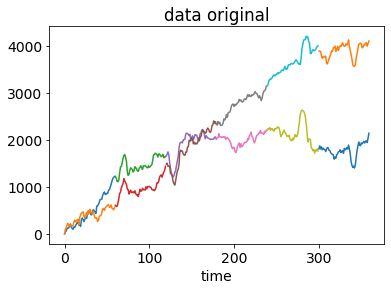

In [ ]:
str0 = f'ts_L60_Z12_A500_DX50_bias5_N10000.dat'
fnamex='DATA/x_'+str0
fnamey='DATA/y_'+str0

x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
param = {'dim':2, 'Z':12, 'A':500, 'N':10000, 'L':60, 'DX':50, 'bias':5 }
locals().update(param)
x = x.reshape((N,L,dim))
Show_data(x,L,"data original", nsegments=6)

categ = np.loadtxt(fnamey, dtype=int)
n_class = 3    # y.argmax() - y.argmin() +1

y = np.zeros((N,n_class))
for i in range(N):
    y[i][categ[i]] = 1.

### Normalize

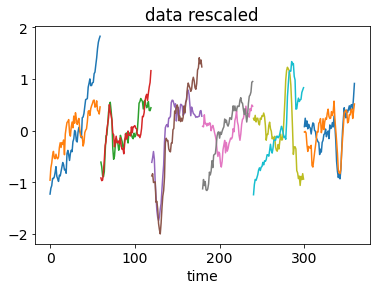

N_train= 8000   N_val= 2000   L= 60   n_class= 3


In [ ]:
#
#  FIRST PASSAGE:  DO NOT DO THIS --> FAILURE 
#
#remove average value of each sample from its values
xm = x.mean(axis=1)
for i in range(N):
    x[i] = x[i]-xm[i]

#
#  SECOND PASSAGE:  DO NOT DO THIS --> ALSO FAILURE 
#
#rescale (crude version, variance should be used)
x = x/400
    
Show_data(x,L,"data rescaled", nsegments=6)

perc_train=0.8
N_train = int(perc_train*N)
x_train = x[:N_train]
y_train = y[:N_train]
x_val = x[N_train:]
y_val = y[N_train:]
N_val = len(x_val)
print('N_train=',N_train,'  N_val=',N_val,'  L=',L,'  n_class=',n_class)

#x_train=x_train.astype("float32")
#y_train=y_train.astype("float32")
#x_val=x_val.astype("float32")
#y_val=y_val.astype("float32")

# Keras wants an additional dimension with a 2 at the end
x_train = x_train.reshape(x_train.shape[0], L, 2)
x_val =  x_val.reshape(x_val.shape[0], L, 2)
input_shape = (L, 2)

## Convolutional NN

In [ ]:
np.random.seed(12345)
import tensorflow.random as tf_r
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, AveragePooling1D
tf_r.set_seed(12345)


reg = tf.keras.regularizers.l2(0.2) ## raised to 0.2
#reg = regularizers.l1(0.1)
ini = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)

input_shape = (L, 2)
model_best_last_year = Sequential()
model_best_last_year.add(Conv1D(filters=8, kernel_size=3, 
                     kernel_initializer=ini, 
                     kernel_regularizer=reg,
                     activation='relu', 
                     input_shape=input_shape))
model_best_last_year.add(Conv1D(filters=8, kernel_size=9, 
                     activation='sigmoid'))
model_best_last_year.add(Conv1D(filters=4, kernel_size=3, 
                     activation='relu'))
model_best_last_year.add(GlobalMaxPooling1D())
model_best_last_year.add(Flatten())
model_best_last_year.add(Dense(3, activation='softmax'))

print('-------- Global Pooling Model-------')
print(model_best_last_year.summary())

opt = tf.keras.optimizers.Adam()
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False,
                                                label_smoothing=0.0,
                                                axis=-1,
                                                reduction="auto",
                                                name="categorical_crossentropy",
                                                )



model_best_last_year.compile(loss=loss, optimizer=opt,metrics=['accuracy'])

-------- Global Pooling Model-------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 58, 8)             56        
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 8)             584       
                                                                 
 conv1d_2 (Conv1D)           (None, 48, 4)             100       
                                                                 
 global_max_pooling1d (Globa  (None, 4)                0         
 lMaxPooling1D)                                                  
                                                                 
 flatten (Flatten)           (None, 4)                 0         
                                                                 
 dense (Dense)               (None, 3)                 15        
                   

In [ ]:
model_best_last_year.layers


In [ ]:
# ...LESSON ...
# Hyper-parameters
# with small minibatch it does not converge!! 
BATCH_SIZE = 100
EPOCHS = 50


print('----- Model ','-----\nFITTING....')
fit = model_best_last_year.fit(x_train,y_train,batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(x_val, y_val),
                verbose=2, shuffle=True) 

----- Model  -----
FITTING....
Epoch 1/50
80/80 - 1s - loss: 1.0971 - accuracy: 0.3521 - val_loss: 1.0908 - val_accuracy: 0.3335 - 1s/epoch - 15ms/step
Epoch 2/50
80/80 - 1s - loss: 1.0506 - accuracy: 0.4170 - val_loss: 0.9868 - val_accuracy: 0.5105 - 604ms/epoch - 8ms/step
Epoch 3/50
80/80 - 1s - loss: 0.9340 - accuracy: 0.5663 - val_loss: 0.8718 - val_accuracy: 0.6105 - 604ms/epoch - 8ms/step
Epoch 4/50
80/80 - 1s - loss: 0.8275 - accuracy: 0.6570 - val_loss: 0.7831 - val_accuracy: 0.6925 - 593ms/epoch - 7ms/step
Epoch 5/50
80/80 - 1s - loss: 0.7605 - accuracy: 0.7372 - val_loss: 0.7281 - val_accuracy: 0.8020 - 578ms/epoch - 7ms/step
Epoch 6/50
80/80 - 1s - loss: 0.7037 - accuracy: 0.8479 - val_loss: 0.6691 - val_accuracy: 0.8895 - 589ms/epoch - 7ms/step
Epoch 7/50
80/80 - 1s - loss: 0.6389 - accuracy: 0.8800 - val_loss: 0.5941 - val_accuracy: 0.8835 - 597ms/epoch - 7ms/step
Epoch 8/50
80/80 - 1s - loss: 0.5601 - accuracy: 0.9031 - val_loss: 0.5132 - val_accuracy: 0.9200 - 564ms/epoc

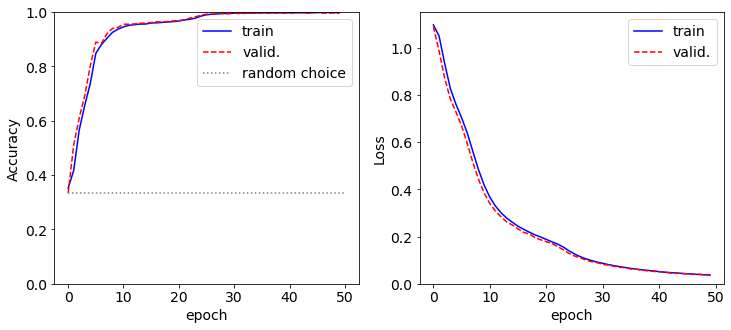

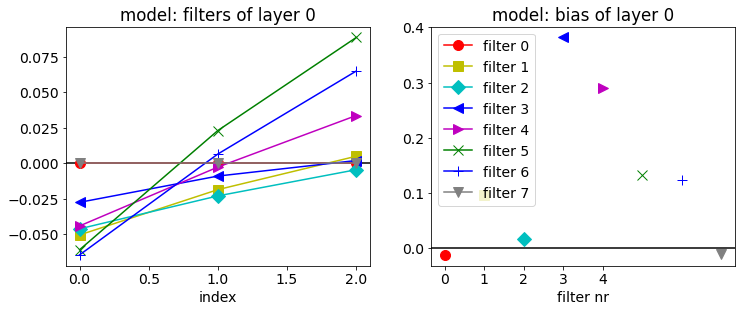

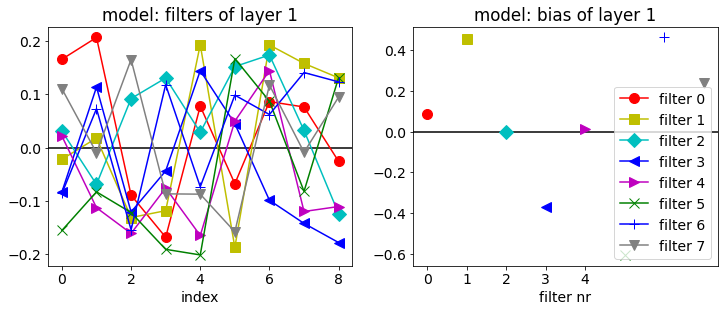

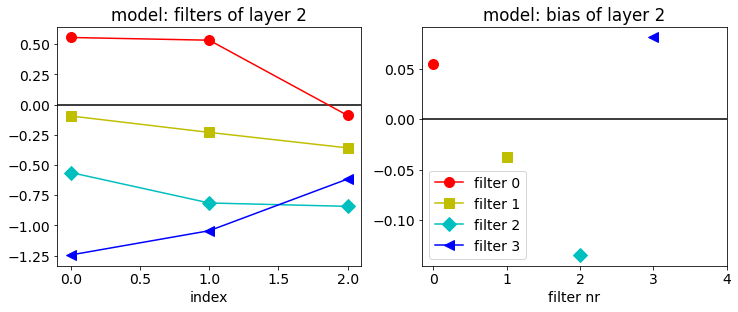

In [ ]:
def Show_history(fit):
    fig,AX=plt.subplots(1,2,figsize=(12,5.))
    ax=AX[0]
    ax.plot(fit.history['accuracy'],"b",label="train")
    ax.plot(fit.history['val_accuracy'],"r--",label="valid.")
    ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray",label="random choice")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.set_ylim([0, 1])
    ax.legend()
    ax=AX[1]
    ax.plot(fit.history['loss'],"b",label="train")
    ax.plot(fit.history['val_loss'],"r--",label="valid.")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Loss")
    ax.set_ylim([0, 1.05*np.max(fit.history['loss'])])
    ax.legend()
    plt.show()

def Show_weights(model_best_last_year,l=0,label="model"):
    c=['r','y','c','b','m','g', 'b', 'grey']
    m=['o','s','D','<','>', 'x', '+', 'v']
    ms=10
    
    w = model_best_last_year.layers[l].get_weights()[0]
    wT=w.T
    M=len(wT)
    b = model_best_last_year.layers[l].get_weights()[1]
    
    fig,AX=plt.subplots(1,2,figsize=(12,4.4))
    ax=AX[0]
    ax.axhline(0, c="k")
    ax.plot((0,))
    for i in range(M):
        ax.plot(wT[i][0],"-",c=c[i],marker=m[i],label=str(i),markersize=ms)
    ax.set_title(label+': filters of layer '+str(l))
    ax.set_xlabel('index')
    ax=AX[1]
    ax.axhline(0, c="k")
    for i in range(M):
        ax.plot((i),(b[i]),c=c[i],marker=m[i],label="filter "+str(i),markersize=ms)
    ax.set_title(label+': bias of layer '+str(l))
    ax.set_xlabel('filter nr')
    ax.set_xticks(np.arange(5))
    ax.legend()
    plt.show()

Show_history(fit)

Show_weights(model_best_last_year,0)
Show_weights(model_best_last_year,1)
Show_weights(model_best_last_year,2)


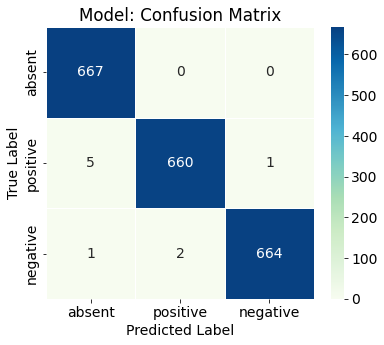

In [ ]:
import pandas as pd
from scipy import stats

import seaborn 
from sklearn import metrics

from sklearn.metrics import classification_report
from sklearn import preprocessing

LABELS = ["absent","positive","negative"]
cmap="GnBu"

def show_confusion_matrix(validations, predictions, label="Model"):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 5))
    seaborn.heatmap(matrix,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d',
                linecolor='white',
                linewidths=1,
                cmap=cmap)
    plt.title(label+': Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_val = model_best_last_year.predict(x_val)
# Take the class with the highest probability from the val predictions
max_y_pred_val = np.argmax(y_pred_val, axis=1)
max_y_val = np.argmax(y_val, axis=1)

show_confusion_matrix(max_y_val, max_y_pred_val)

#print(classification_report(max_y_val, max_y_pred_val))

### Conclusions
The model with the three convolution layers followed by the global pooling has a very good performance: the accuracy of both training and validation is higher than 99%. It converges in a stable way, in a low number of epochs, even when using small batches size. It is possible to conclude that the model suggested is succesful on a 2 dimensional time-serie.
This result makes perfect sense: with this structure, the network focuses only on detecting the presence of the pattern, disregarding its position, and the sizes of the filters are adequate for detecting the pattern.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9d991341-85e0-460c-ac0b-888d6f039546' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>